In [1352]:
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mesa import Agent
from mesa import Model
from mesa.datacollection import DataCollector
from mesa.space import Grid
from mesa.time import RandomActivation
from mesa.batchrunner import BatchRunner

In [1610]:
def get_mining_summary(model):
    try:
        df = model.blockchain.mempool
        frac_unmined = df['block_mined'].isna().sum() / len(df)
        
        df = df.dropna()
        df['mining_time'] = df['block_mined'] - df['block_submitted']

        s = df['mining_time'].astype(int).describe() 
        s['frac_unmined'] = frac_unmined
        
        return s
        
    except:
        return "Failed on tick " + str(model.schedule.steps) 

In [1647]:
def get_agent_expiry_ticks(model):
    # In analysis will need to check expiry ticks column and 
    # cast to int to get summary stats.
    
    s = pd.DataFrame(columns=['unique_id', 'expiry_tick'])
    
    for a in model.schedule.agents:
        s = s.append({'unique_id': int(a.unique_id), 'expiry_tick': a.dead}, ignore_index=True)
    
    survival_rate = s['expiry_tick'].isna().sum() / len(s)
    
    s = s[['expiry_tick']].dropna().astype(int).describe()
    s.loc['survival_rate'] = survival_rate
    
    return s

In [645]:
def get_informational_currency(agent, window=1):
    """
    Calculate the proportion of data collected by a 
    sensor that has been committed to the chain.
    
    **Note: This counts each tick as equal, even if 
    different volumes of data were collected during
    the ticks.**
    
    Attributes:
        agent: The Sensor for which to calculate 
            informational currency measure.
        window: The window through which to measure. 
        
            If window = 1, check proportion of data 
            reflected on chain from all time.
            
            If window > 1, check proportion of data in 
            most recent n=window ticks that is reflected 
            on chain
    """
    
    model = agent.model
    agent_id = agent.unique_id
    
    if window == 1 or window > len(model.blockchain.chain):
        try:
            return model.blockchain.chain[agent_id].value_counts()[True] / len(model.blockchain.chain[agent_id])
        except KeyError:
            return 0
    
    else:
        df = model.blockchain.chain[window * -1 :] # Last n rows
        try:
            return df[agent_id].value_counts()[True] / len(df[agent_id])
        except KeyError:
            return 0


In [859]:
def create_tx_dict(from_address, nonce, start, end, gas_price, num_bytes):
    """
    Assemble variables into a dictionary representing 
    an (abstracted) Ethereum transaction.
    """
    
    tx = {}
        
    tx['nonce'] = nonce
    tx['from_address'] = from_address # << Sensor ID
    tx['start_sync'] = start
    tx['end_sync'] = end
    tx['gas_price'] = gas_price
    # self.gas_limit = gas_limit # << unused parameter
    tx['num_bytes'] = num_bytes

    return tx

In [1557]:
class Sensor(Agent):
    """
    An edge device. 
    
    Attributes:
        battery_life: Total battery on board.
        mortal: a boolean value indicating whether the agent should
            cease activity once battery is depleted.
        record_cost, record_freq, record_bytes: Values
            to calculate sensor recording behavior
        compute_cost_per_byte: An abstracted link between
            bytes computed and energy consumed
        info_reduction: An abstracted scaling metric to 
            calculate the amount of data to transmit based
            on the amount of data collected at the edge. 
            Represents edge computing capability.
        sign_cost: An estimate of the energy consumed to sign a tx. 
        transmit_cost_per_byte: A link between bytes transmitted
            and energy consumed
        transmit_freq: How often data is transmitted from the sensor
            to the blockchain. If n > 1, every n ticks. If n < 1, 
            n is the probability of transmitting each tick
        gas_price: The gas_price a sensor is willing to pay to get 
            its transactions mined by the EVM.
        blockchain: a pointer to the blockchain each sensor is 
            connecting to, so it can invoke class methods
        stochasticity: The measure of randomness, applied when 
            appropriate, to simulate variation
        model: The model that is creating the sensor.
        
    """
    def __init__(self, unique_id, battery_life, mortal,
                record_cost, record_freq, record_bytes, 
                compute_cost_per_byte, info_reduction,
                sign_cost,
                transmit_cost_per_byte, transmit_freq,
                gas_price, blockchain, stochasticity,
                model):
        
        super().__init__(unique_id, model)
        
        if self.model.verbose:
            print('Creating Sensor agent ID', unique_id)
           
        self.battery_life = battery_life
        self.mortal = mortal
        self.dead = np.nan
        self.record_cost = record_cost
        self.record_freq = record_freq
        self.record_bytes = record_bytes
        self.compute_cost_per_byte = compute_cost_per_byte
        self.info_reduction = info_reduction
        self.sign_cost = sign_cost
        self.transmit_cost_per_byte = transmit_cost_per_byte
        self.transmit_freq = transmit_freq
        self.gas_price = gas_price
        self.blockchain = blockchain
        self.stochasticity = stochasticity
        
        self.gwei_spent = 0
        self.data_collected = 0
        self.last_sync = 0
        self.nonce = 0
        self.db = np.array([]) # << bytes recorded per tick
        
        self.blockchain.chain.loc[0, self.unique_id] = False

    
    def record(self):
        if (self.record_freq > 1 and self.model.schedule.steps % self.record_freq == 0) or self.record_freq > random.random():

                self.battery_life -= self.record_cost # << independent of number of bytes? 
                new_record = self.record_bytes
                if self.stochasticity:
                    new_record = math.ceil(new_record  * (1 + random.uniform(self.stochasticity * -1, self.stochasticity)))

                self.db = np.append(self.db, new_record)

        else:
            self.db = np.append(self.db, 0)

            
    def next_nonce(self):
        self.nonce += 1
        return self.nonce
   

    def transmit(self):
        
        if self.model.verbose:
            print("Transmitting tx from", self.unique_id)

        # Prepare data for transmission:
        
        # Calculate number of bytes to transmit (result of edge computation)
        bytes_collected = np.sum(self.db[self.last_sync : ])
        num_bytes_to_transmit = self.compute(bytes_collected)
        
        if num_bytes_to_transmit > 0:

            tx = create_tx_dict(self.unique_id, self.next_nonce(), 
                           self.last_sync, self.model.schedule.steps, 
                           self.gas_price, num_bytes_to_transmit)

            # Prepare and sign tx
            self.sign()

            # Transmit, subtracting energy cost and adding gwei cost
            self.battery_life -= self.transmit_cost_per_byte * num_bytes_to_transmit
            self.blockchain.add_to_mempool(tx)

            self.last_sync = self.model.schedule.steps
    
    
    def compute(self, num_bytes):
        
        # Only invoked from within the transmit() method
        
        if self.info_reduction is not 1:
            self.battery_life -= self.compute_cost_per_byte * num_bytes
            return math.ceil(self.info_reduction * num_bytes)
        else:
            return num_bytes
            # with no compute cost
    
    
    def sign(self):
        
        # Only invoked from within the transmit() method
        self.battery_life -= self.sign_cost
    
    
    def confirm_tx(self, tx):
        
        # Here we could include learning element ...

#         mine_lag =  self.model.schedule.steps - tx.block_submitted
        # if mine_lag took too long - or was too quick - according to some threshold:
        #      change transmit_freq, info_reduction or gas_price ...
        
        self.gwei_spent += tx.gas_spend
    
    
    def total_data_collected(self):
        return self.db.sum()
    
    
    def step(self):
        
        if math.isnan(self.dead):   
            if self.battery_life < 0 and self.mortal:
                if self.model.verbose:
                    print("Sensor", self.unique_id, "out of battery at tick", self.model.schedule.steps)
                self.dead = self.model.schedule.steps

            self.record()    

            if self.transmit_freq >= 1:
                if self.model.schedule.steps % self.transmit_freq == 0:
                    self.transmit()
            elif self.transmit_freq > random.random():
                self.transmit()



In [981]:
class Blockchain(Agent):
    
    def __init__(self, unique_id, gas_price, block_gas_limit,
                gas_per_byte, gas_per_second, avg_block_time, model):
        
        super().__init__(unique_id, model)
        
        if self.model.verbose:
            print("Blockchain created: ID", unique_id)
        
#         self.unique_id = unique_id
        self.gas_price = gas_price
        self.block_gas_limit = block_gas_limit
        self.gas_per_byte = gas_per_byte
        self.gas_per_second = gas_per_second
        self.avg_block_time = avg_block_time
        self.chain = pd.DataFrame()
        
        self.tx_ct = 0
        self.mempool = pd.DataFrame(columns=["from_address", "nonce", 
                                             "start_sync", "end_sync", 
                                             "gas_price", "num_bytes", 
                                             "gas_spend", "tx_id",
                                             "mined", "block_submitted"])

    def add_to_mempool(self, tx):
        tx['gas_spend'] = tx['gas_price'] * self.gas_per_byte * tx['num_bytes']

        tx['tx_id'] = self.tx_ct
        tx['mined'] = False
        tx['block_submitted'] = self.model.schedule.steps
        row = pd.DataFrame(tx, index = [self.tx_ct])
        
        self.tx_ct += 1
        self.mempool = self.mempool.append(row, ignore_index=True)
    
    def write_data(self, num_bytes):

        gwei_spent = self.gas_per_byte * num_bytes * self.gas_price
        return gwei_spent

    def mine_block(self):
        
        if self.model.verbose:
            print("Mining BLOCK NUMBER:", self.model.schedule.steps)
        self.chain.loc[self.model.schedule.steps] = [False for col in self.chain.columns]

        # Sort mempool to get highest-value transactions
        mp = self.mempool[self.mempool['mined'] == False].sort_values(by=['gas_spend', 'block_submitted']).reset_index()
        
        if len(mp) > 0:
            
            mp['cum_gas'] = mp['gas_spend'].cumsum()     
            if mp['cum_gas'].max() > self.block_gas_limit:
                
                # If we cannot include all transactions in a block, fit as many as possible ...
                tx_mined = mp[0 : mp[mp['cum_gas'] > self.block_gas_limit].index[0] - 1]
                
            else:
                tx_mined = mp[0 : ]
            
            if self.model.verbose:
                print("Mining", len(tx_mined), "out of", len(mp), "unvalidated transactions.\n")
                print("Gas value:", tx_mined['gas_spend'].sum(), '\n')
            
            for tx in tx_mined.iterrows():
                
                if self.model.verbose:
                    print("Mining tx id:", tx[1].tx_id)
                    
                self.model.schedule._agents[tx[1].from_address].confirm_tx(tx[1])
                self.mempool.loc[self.mempool['tx_id'] == tx[1].tx_id, "mined"] = True
                self.mempool.loc[self.mempool['tx_id'] == tx[1].tx_id, "block_mined"] = self.model.schedule.steps
                
                self.chain.loc[tx[1].start_sync : tx[1].end_sync, tx[1].from_address] = True
                
        else:
            if self.model.verbose:
                print('Empty mempool')
            pass
        
        if self.model.verbose:
            print('\n')
    
    # Not used:
    def compute(self, num_seconds):
        gwei_spent = self.gas_per_second * num_seconds * self.gas_price
        return gwei_spent
    

In [1523]:
class SensorBlockchainNetwork(Model):
    
    def __init__(self, num_sensors,
                 stochasticity=0,
       # Blockchain vars:
                 blockchain_gas_price=20,
                 block_gas_limit=9000000,
                 gas_per_byte=625,
                 gas_per_second=75000000,
                 avg_block_time=13,
                    # gas_per_byte and gas_per_second calculated based on 
                    # https://hackernoon.com/ether-purchase-power-df40a38c5a2f
                
        # Sensor vars:
                 battery_life=1000,
                 record_cost=1, record_freq=1, record_bytes=32,
                 compute_cost_per_byte=1, info_reduction=1,
                 sign_cost=0.1, 
                 transmit_cost_per_byte=1, transmit_freq=1,
                 sensor_gas_price=20,
                 mortal=True,
                 
                 # Model vars:
                 verbose=False):
        
        super().__init__()
        
        
        self.verbose = verbose
        if self.verbose:
            print('Verbose model')
        
        self.running = True
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
                                model_reporters = {
                                    "active_sensors": lambda m: len([a for a in m.schedule.agents if not a.dead]),
                                    # chain size
                                    # information availability   
                                },
                                agent_reporters = {
                                    "gwei_spent": lambda a: a.gwei_spent,
                                    "battery_life": lambda a: a.battery_life,
                                    "data_collected": lambda a: a.total_data_collected(),
                                    "informational_currency": lambda a: get_informational_currency(a, 20)
                                })
        
        self.blockchain = Blockchain(self.next_id(), blockchain_gas_price, block_gas_limit,
                                    gas_per_byte, gas_per_second, avg_block_time, self) 

        
        for i in range(num_sensors):
            sensor = Sensor(self.next_id(), battery_life, mortal,
                            record_cost, record_freq, record_bytes,
                            compute_cost_per_byte, info_reduction, 
                            sign_cost,
                            transmit_cost_per_byte, transmit_freq, 
                            sensor_gas_price,
                            self.blockchain, stochasticity, # << each sensor gets the same amount of stochasticity?
                            self)
            
            self.schedule.add(sensor)
    
        # Mine genesis block
        self.blockchain.chain.loc[1] = [False for col in self.blockchain.chain.columns]

        if self.verbose:
            print(num_sensors, "instantiated and added to schedule.")
    
    def step(self):
        self.schedule.step()
        if self.schedule.steps > 1:
            self.blockchain.mine_block()
        self.datacollector.collect(self)

In [1629]:
model = SensorBlockchainNetwork(
    blockchain_gas_price= 20,
    block_gas_limit=8000000,
    gas_per_byte= 625,
    gas_per_second= 75000000,
    avg_block_time=13,
    verbose=False,
    battery_life=10000,
    mortal= True,
    
    num_sensors=10,
    stochasticity=0,
    record_bytes=32)

In [1630]:
for i in range(500):
    model.step()

# Model Execution and Analysis

Here we instantiate a mesa BatchRunner object, which contains methods for iterating through the arrays of variable parameters we pass in and executing a model for each arrangement. As a result we can access a pandas dataframe that contains all the agent, model tick and model run variables, as defined in the SensorBlockchainNetwork class definition, and in the model_reporters parameter passed into the BatchRunner object instantiation. 

We pass this dataframe into the following functions to extract relevant data and metrics, to be analyzed and visualized to discern system dynamic across the range of parameters swept. 

In [1296]:
def extract_mining_summary_from_batch_df(batch_df):
    """
    A function extracting mining descriptive statistics
    from the dataframe returned from the 
    batchrunner.get_model_vars_dataframe() method invocation
    """
    df = pd.DataFrame(columns=['num_sensors',  'record_freq', 'record_bytes', 'stochasticity', 'mean_mining_time', 'std', 'min', 'max'])

    for i, row in batch_df.iterrows():

        df.loc[i, 'record_freq'] = row['record_freq']
        df.loc[i, 'num_sensors'] = row['num_sensors']
        df.loc[i, 'record_freq'] = row['record_freq']
        df.loc[i, 'record_bytes'] = row['record_bytes']
        df.loc[i, 'stochasticity'] = row['stochasticity']

        try:
            df.loc[i, 'mean_mining_time'] = row['mining_summary']['mean']
            df.loc[i, 'std'] = row['mining_summary']['std']
            df.loc[i, 'min'] = row['mining_summary']['min']
            df.loc[i, 'max'] = row['mining_summary']['max']
        except:
            df.loc[i, 'mean_mining_time'] = row['mining_summary']
    
    return df

In [1268]:
def extract_gwei_spent_from_batch_df(batch_df):
    df_tmp = pd.DataFrame(columns=['num_sensors',  'record_freq', 'record_bytes', 'stochasticity'])

    for i, row in batch_df.iterrows():
        df_tmp.loc[i, 'num_sensors'] = row['num_sensors']
        df_tmp.loc[i, 'record_freq'] = row['record_freq']
        df_tmp.loc[i, 'record_bytes'] = row['record_bytes']
        df_tmp.loc[i, 'stochasticity'] = row['stochasticity']

        df_gwei = row['data_collector'].get_agent_vars_dataframe()['gwei_spent'].unstack()

        for col in df_gwei.columns:
            df_gwei[str(col) + '_shift'] = df_gwei[col].shift(1)
            df_gwei[str(col) + '_gwei_spend'] = df_gwei[col] - df_gwei[str(col) + '_shift']

        df_gwei = df_gwei[[col for col in df_gwei.columns if 'spend' in str(col)]]

        df_tmp.loc[i, 'df_gwei_spent'] = InfoCurrency(df_gwei)

    return df_tmp

In [1204]:
class InfoCurrency:
    """ A cheeky workaround to store dataframes as a value in another dataframe ..."""
    def __init__(self, df):
        self.df = df

def extract_informational_currency_from_batch_df(batch_df):
    
    df_tmp = pd.DataFrame(columns=['num_sensors',  'record_freq', 'record_bytes', 'stochasticity', 'info_currency_df'])
    for i, row in batch_df.iterrows():
        df_tmp.loc[i, 'num_sensors'] = row['num_sensors']
        df_tmp.loc[i, 'record_freq'] = row['record_freq']
        df_tmp.loc[i, 'record_bytes'] = row['record_bytes']
        df_tmp.loc[i, 'stochasticity'] = row['stochasticity']

        df_tmp.loc[i, 'info_currency_df'] = InfoCurrency(row['data_collector'].get_agent_vars_dataframe()['informational_currency'].unstack())
    
    return df_tmp

In [1241]:
def extract_network_life_cycle_from_batch_df(batch_df):
    return batch_df[[ 'num_sensors','record_bytes', 'record_freq', 'stochasticity', 'agent_expiry_ticks']]

In [1253]:
fixed_params = {
    "blockchain_gas_price": 20,
    "block_gas_limit": 8000000,
    "gas_per_byte": 625,
    "gas_per_second": 75000000,
    "avg_block_time": 13,
    "verbose": False,
    "battery_life": 10000,
    
    "num_sensors": 10,
    "stochasticity": 0
}

variable_params = {
    "num_sensors": range(1, 110, 10),
    "stochasticity": np.arange(0, 1, 0.1),
    "record_bytes": [1, 10, 100],
    "record_freq": [0.001, 0.01, 0.1, 1]
}

# Initial parameter sweep

Our initial batch run swept across several values in several dimensions. We collected a lot of data, and analyzed it to identify areas where a more specific sweep would be sensible. 

In [1259]:
# Batch Run

batch_runner = BatchRunner(
    SensorBlockchainNetwork,
    variable_params,
    fixed_params,
    iterations = 1,
    max_steps = 300,
    model_reporters = {"data_collector": lambda m: m.datacollector,
                      "agent_expiry_ticks": get_agent_expiry_ticks,
                      "mining_summary": get_mining_summary}
)

In [1260]:
batch_runner.run_all()

1320it [2:54:47,  7.26s/it]


In [1261]:
batch_df = batch_runner.get_model_vars_dataframe()

In [1297]:
mining_summary = extract_mining_summary_from_batch_df(batch_df)


In [1265]:
info_currency_summary = extract_informational_currency_from_batch_df(batch_df)


In [1266]:
network_life_cycle_summary = extract_informational_currency_from_batch_df(batch_df)


In [1269]:
gwei_spent_summary = extract_gwei_spent_from_batch_df(batch_df)

In [1300]:
mining_summary.to_pickle('./data/run-1/mining-summary.pkl')
info_currency_summary.to_pickle('./data/run-1/info-currency-summary.pkl')
network_life_cycle_summary.to_pickle('./data/run-1/network-life-cycle-summary.pkl')
gwei_spent_summary.to_pickle('./data/run-1/gwei-spent-summary.pkl')


## Sweeping Record Frequency

In [1524]:
fixed_params_2 = {
    "blockchain_gas_price": 20,
    "block_gas_limit": 8000000,
    "gas_per_byte": 625,
    "gas_per_second": 75000000,
    "avg_block_time": 13,
    "verbose": False,
    "battery_life": 10000,
    "mortal": False,
    
    "num_sensors": 10,
    "stochasticity": 0,
    "record_bytes": 32
}

variable_params_record_freq = {
    "record_freq": [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
}

In [ ]:
batch_runner_record_freq = BatchRunner(
    SensorBlockchainNetwork,
    variable_params_record_freq,
    fixed_params_2,
    iterations = 1,
    max_steps = 300,
    model_reporters = {"data_collector": lambda m: m.datacollector,
                      "agent_expiry_ticks": get_agent_expiry_ticks,
                      "mining_summary": get_mining_summary}
)

In [ ]:
batch_runner_record_freq.run_all()

In [1345]:
batch_record_freq_df = batch_runner_record_freq.get_model_vars_dataframe()

In [ ]:
batch_record_freq_df.to_pickle('./sweep_record_freq.pkl')

In [1347]:
batch_record_freq_mining_summary = extract_mining_summary_from_batch_df(batch_record_freq_df)

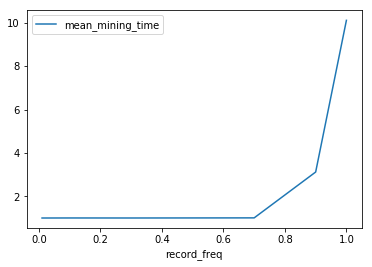

In [1355]:
batch_record_freq_mining_summary.plot.line(x='record_freq',y='mean_mining_time')

## Sweeping Record Bytes

In [1644]:
fixed_params_3 = {
    "blockchain_gas_price": 20,
    "block_gas_limit": 8000000,
    "gas_per_byte": 625,
    "gas_per_second": 75000000,
    "avg_block_time": 13,
    "verbose": False,
    "battery_life": 10000,
    "mortal": True,
    
    "num_sensors": 10,
    "stochasticity": 0,
    "record_freq": 0.5
}

variable_params_record_bytes = {
    "record_bytes": [10, 20, 32, 40, 50, 70, 100]
}

In [1648]:
batch_runner_record_bytes_2 = BatchRunner(
    SensorBlockchainNetwork,
    variable_params_record_bytes,
    fixed_params_3,
    iterations = 1,
    max_steps = 200,
    model_reporters = {"data_collector": lambda m: m.datacollector,
                      "agent_expiry_ticks": get_agent_expiry_ticks,
                      "mining_summary": get_mining_summary}
)

In [1367]:
batch_runner_record_bytes.run_all()

0it [00:00, ?it/s]/Users/iv/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
7it [01:52, 13.88s/it]


In [1649]:
batch_runner_record_bytes_2.run_all()

4it [00:49, 12.43s/it]/Users/iv/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
7it [01:19, 10.44s/it]


In [1368]:
batch_runner_record_bytes_df = batch_runner_record_bytes.get_model_vars_dataframe()

In [1650]:
batch_runner_record_bytes_df_2 = batch_runner_record_bytes_2.get_model_vars_dataframe()

In [1651]:
batch_runner_record_bytes_df_2

,record_bytes,Run,agent_expiry_ticks,data_collector,mining_summary,blockchain_gas_price,block_gas_limit,gas_per_byte,gas_per_second,avg_block_time,verbose,battery_life,mortal,num_sensors,stochasticity,record_freq
0,10,0,expiry_tick count ...,<mesa.datacollection.DataCollector object at 0...,count 1498.000000 mean ...,20,8000000,625,75000000,13,False,10000,True,10,0,0.5
1,20,1,expiry_tick count ...,<mesa.datacollection.DataCollector object at 0...,count 1523.000000 mean ...,20,8000000,625,75000000,13,False,10000,True,10,0,0.5
2,32,2,expiry_tick count ...,<mesa.datacollection.DataCollector object at 0...,count 1552.000000 mean ...,20,8000000,625,75000000,13,False,10000,True,10,0,0.5
3,40,3,expiry_tick count ...,<mesa.datacollection.DataCollector object at 0...,count 1477.000000 mean ...,20,8000000,625,75000000,13,False,10000,True,10,0,0.5
4,50,4,expiry_tick count 4...,<mesa.datacollection.DataCollector object at 0...,count 1447.000000 mean ...,20,8000000,625,75000000,13,False,10000,True,10,0,0.5
5,70,5,expiry_tick count 10...,<mesa.datacollection.DataCollector object at 0...,count 996.000000 mean 22...,20,8000000,625,75000000,13,False,10000,True,10,0,0.5
6,100,6,expiry_tick count 10...,<mesa.datacollection.DataCollector object at 0...,count 712.000000 mean 29...,20,8000000,625,75000000,13,False,10000,True,10,0,0.5


### Mining summary

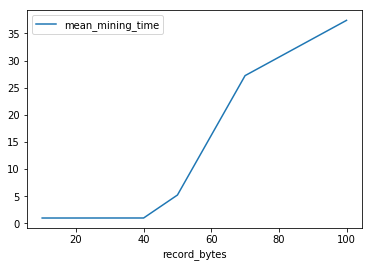

In [1528]:
batch_record_bytes_mining_summary_df = extract_mining_summary_from_batch_df(batch_runner_record_bytes_df)
batch_record_bytes_mining_summary_df.plot.line(x='record_bytes', y='mean_mining_time')

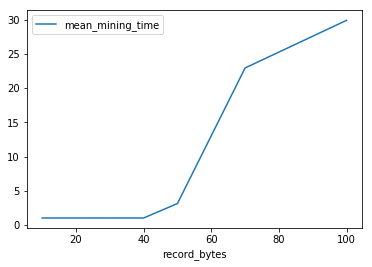

In [1652]:
batch_record_bytes_mining_summary_df_2 = extract_mining_summary_from_batch_df(batch_runner_record_bytes_df_2)
batch_record_bytes_mining_summary_df_2.plot.line(x='record_bytes', y='mean_mining_time')

In [1576]:
batch_record_bytes_mining_summary_df_2

,num_sensors,record_freq,record_bytes,stochasticity,mean_mining_time,std,min,max
0,10,0.5,10,0,1.00175,0.0418395,1,2
1,10,0.5,20,0,1.00179,0.04222,1,2
2,10,0.5,32,0,1.00112,0.0335088,1,2
3,10,0.5,40,0,1.00157,0.0395948,1,2
4,10,0.5,50,0,Failed on tick 600,NaN,NaN,NaN
5,10,0.5,70,0,Failed on tick 600,NaN,NaN,NaN
6,10,0.5,100,0,Failed on tick 600,NaN,NaN,NaN


### Gwei spent

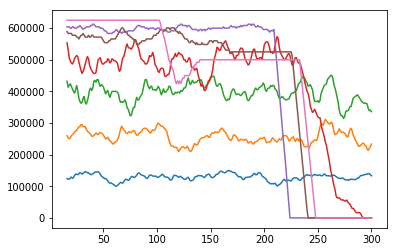

In [1419]:
batch_record_bytes_gwei_spent_df = extract_gwei_spent_from_batch_df(batch_runner_record_bytes_df)
for i in range(len(batch_record_bytes_gwei_spent_df)):
    plt.plot(batch_record_bytes_gwei_spent_df['df_gwei_spent'][i].df.mean(axis=1).rolling(15).mean())


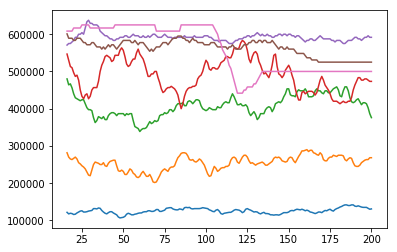

In [1653]:
batch_record_bytes_gwei_spent_df_2 = extract_gwei_spent_from_batch_df(batch_runner_record_bytes_df_2)
for i in range(len(batch_record_bytes_gwei_spent_df_2)):
    plt.plot(batch_record_bytes_gwei_spent_df_2['df_gwei_spent'][i].df.mean(axis=1).rolling(15).mean())

### Agent Expiry

Need to revisit after rerunning models with np.nan instead of False, so as to not affect expiry tick mean calculation.

In [1617]:
batch_runner_record_bytes_agent_expiry_df_2 = extract_network_life_cycle_from_batch_df(batch_runner_record_bytes_df_2)

In [1618]:
batch_runner_record_bytes_agent_expiry_df_2['agent_expiry_ticks'][4]

,unique_id,expiry_tick
count,10.00000,0.0
mean,6.50000,NaN
std,3.02765,NaN
min,2.00000,NaN
25%,4.25000,NaN
50%,6.50000,NaN
75%,8.75000,NaN
max,11.00000,NaN
survival_rate,0.00000,0.0


### Informational currency

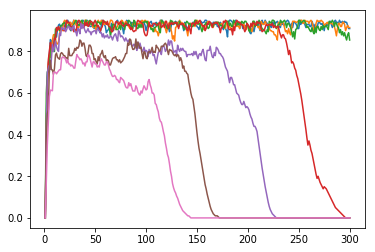

In [1535]:
batch_runner_record_bytes_info_currency_df = extract_informational_currency_from_batch_df(batch_runner_record_bytes_df)
for i in range(len(batch_runner_record_bytes_info_currency_df)):
    plt.plot(batch_runner_record_bytes_info_currency_df['info_currency_df'][i].df.mean(axis=1))


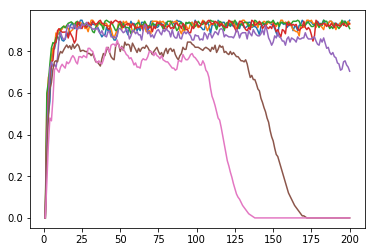

In [1654]:
batch_runner_record_bytes_info_currency_df_2 = extract_informational_currency_from_batch_df(batch_runner_record_bytes_df_2)
for i in range(len(batch_runner_record_bytes_info_currency_df_2)):
    plt.plot(batch_runner_record_bytes_info_currency_df_2['info_currency_df'][i].df.mean(axis=1))


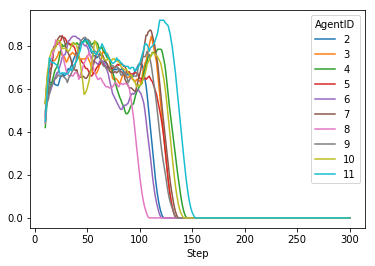

In [1513]:
batch_runner_record_bytes_df['data_collector'][6].get_agent_vars_dataframe().unstack()['informational_currency'].rolling(10).mean().plot()

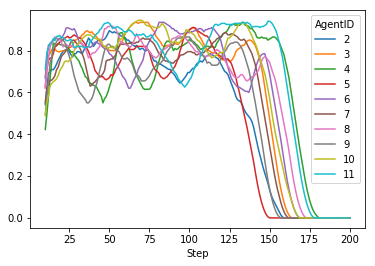

In [1655]:
batch_runner_record_bytes_df_2['data_collector'][5].get_agent_vars_dataframe().unstack()['informational_currency'].rolling(10).mean().plot()

In [1570]:
batch_runner_record_bytes_df_2['data_collector'][2].get_agent_vars_dataframe()

gwei_spent  battery_life  data_collected  \
Step AgentID                                              
1    2                0.0        9966.9            32.0   
     3                0.0       10000.0             0.0   
     4                0.0        9966.9            32.0   
     5                0.0       10000.0             0.0   
     6                0.0       10000.0             0.0   
     7                0.0       10000.0             0.0   
     8                0.0        9966.9            32.0   
     9                0.0       10000.0             0.0   
     10               0.0       10000.0             0.0   
     11               0.0        9966.9            32.0   
2    2          1200000.0        9901.8            64.0   
     3                0.0       10000.0             0.0   
     4           800000.0        9934.8            32.0   
     5           400000.0        9966.9            32.0   
     6           400000.0        9966.9            32.0   
     7                0.0       10000.0             0.0   
     8          1200000.0        9901.8            64.0   
     9                0.0       10000.0             0.0   
     10          400000.0        9966.9            32.0   
     11          800000.0        9934.8            32.0   
3    2          2000000.0        9836.7            96.0   
     3           400000.0        9966.9            32.0   
     4          1200000.0        9901.7            64.0   
     5          1200000.0        9901.8            64.0   
     6          1200000.0        9901.8            64.0   
     7                0.0       10000.0             0.0   
     8          1600000.0        9869.7            64.0   
     9           400000.0        9966.9            32.0   
     10         1200000.0        9901.8            64.0   
     11         1200000.0        9901.7            64.0   
...                   ...           ...             ...   
298  2        119600000.0         260.2          4800.0   
     3        128000000.0        -423.5          5120.0   
     4        117200000.0         454.6          4704.0   
     5        126800000.0        -326.3          5088.0   
     6        127600000.0        -391.2          5120.0   
     7        127600000.0        -391.6          5120.0   
     8        126800000.0        -326.0          5088.0   
     9        122800000.0          -0.4          4928.0   
     10       118000000.0         389.2          4736.0   
     11       121600000.0          97.8          4864.0   
299  2        120400000.0         195.1          4832.0   
     3        128400000.0        -456.6          5152.0   
     4        118000000.0         389.5          4736.0   
     5        127600000.0        -391.4          5120.0   
     6        128000000.0        -423.3          5120.0   
     7        128400000.0        -456.7          5152.0   
     8        127600000.0        -391.1          5120.0   
     9        123600000.0         -65.5          4960.0   
     10       118400000.0         357.1          4736.0   
     11       121600000.0          97.8          4864.0   
300  2        120800000.0         163.0          4832.0   
     3        128800000.0        -488.7          5152.0   
     4        118800000.0         324.4          4768.0   
     5        128400000.0        -456.5          5152.0   
     6        128000000.0        -423.3          5120.0   
     7        129200000.0        -521.8          5184.0   
     8        128400000.0        -456.2          5152.0   
     9        124400000.0        -130.6          4992.0   
     10       118400000.0         357.1          4736.0   
     11       122000000.0          64.7          4896.0   

              informational_currency  
Step AgentID                          
1    2                      0.000000  
     3                      0.000000  
     4                      0.000000  
     5                      0.000000  
     6                      0.000000  
     7                  